In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")
print(df.head())
print(df["Has_Shift"].value_counts())

     image_path Midline_Shift  Surgery_Advisable    processed_image_path  \
0  images/1.jpg           NaN                  1  processed_images/1.jpg   
1  images/2.jpg           NaN                  0  processed_images/2.jpg   
2  images/3.jpg           NaN                  0  processed_images/3.jpg   
3  images/4.jpg         Right                  1  processed_images/4.jpg   
4  images/5.jpg           NaN                  0  processed_images/5.jpg   

   Has_Shift  Midline_Shift_Label  
0          0                    2  
1          0                    2  
2          0                    2  
3          1                    1  
4          0                    2  
Has_Shift
1    621
0    365
Name: count, dtype: int64


In [4]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "processed_image_path"]
        label = int(self.df.loc[idx, "Has_Shift"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Has_Shift"], random_state=42)


In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = BrainDataset(train_df, transform=train_transform)
test_dataset = BrainDataset(test_df, transform=test_transform)

In [8]:
class_counts = df["Has_Shift"].value_counts().sort_index()
neg, pos = class_counts[0], class_counts[1]
inv_class_freq = {0: 1.0 / neg, 1: 1.0 / pos}
sample_weights = [inv_class_freq[int(l)] for l in train_df["Has_Shift"]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 1)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /Users/yaswanth/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:06<00:00, 17.2MB/s] 


In [10]:
model = model.to(device)

In [11]:
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.4811
Epoch [2/10], Loss: 0.3796
Epoch [3/10], Loss: 0.2873
Epoch [4/10], Loss: 0.2569
Epoch [5/10], Loss: 0.2043
Epoch [6/10], Loss: 0.1842
Epoch [7/10], Loss: 0.1413
Epoch [8/10], Loss: 0.0969
Epoch [9/10], Loss: 0.0693
Epoch [10/10], Loss: 0.0617


In [13]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = [int(x) for x in y_true]
y_pred = [int(x) for x in y_pred]

/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_25723/4251740934.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_25723/4251740934.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x) for x in y_pred]



=== Evaluation Results (ConvNeXt-Tiny) ===
Accuracy : 0.8586
Precision: 0.8760
Recall   : 0.9040
F1 Score : 0.8898

Classification Report:

              precision    recall  f1-score   support

    No Shift       0.83      0.78      0.80        73
       Shift       0.88      0.90      0.89       125

    accuracy                           0.86       198
   macro avg       0.85      0.84      0.85       198
weighted avg       0.86      0.86      0.86       198



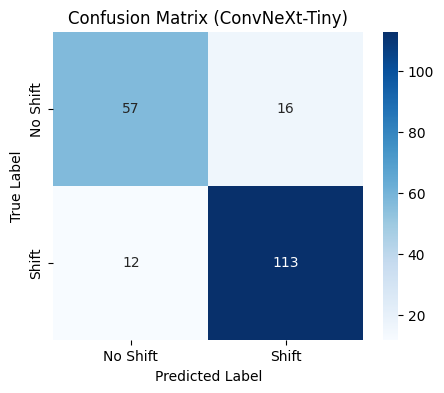

In [14]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\n=== Evaluation Results (ConvNeXt-Tiny) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Shift", "Shift"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Shift", "Shift"],
            yticklabels=["No Shift", "Shift"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ConvNeXt-Tiny)")
plt.show()

In [15]:
torch.save(model.state_dict(), "midline_shift_model_convnext_tiny.pth")
